In [5]:
import pandas as pd, os
# import cudf, cuml, cupy
from tqdm import tqdm
import numpy as np
from glob import glob
# from cuml import UMAP, TSNE
# from cuml.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer, HashingVectorizer
# from cuml import HDBSCAN, DBSCAN
from collections import Counter
import matplotlib.pyplot as plt
import re
from random import choice
# from spacy import displacy
import pandas as pd

In [3]:
texts = []
ids = []
for fname in tqdm(glob('train/*.txt')):
    with open(fname) as f:
        texts.append(f.read())
    ids.append(fname.split('/')[1].split('.')[0])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 15594/15594 [00:00<00:00, 94175.58it/s]


In [4]:
df = cudf.DataFrame({'id': ids, 'text': texts})

In [5]:
tfrm = TfidfVectorizer(stop_words='english', smooth_idf=False, sublinear_tf=True)

In [6]:
m = tfrm.fit_transform(df.text)

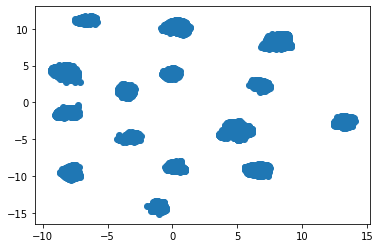

In [161]:
umap = UMAP(n_neighbors=25, min_dist=.3)
embed_2d = umap.fit_transform(m)
embed_2d = cupy.asnumpy( embed_2d )
plt.scatter(embed_2d[:, 0], embed_2d[:, 1])

In [162]:
clst = DBSCAN(eps=1)
cluster_assignement = clst.fit_predict(embed_2d)

In [163]:
def hsv_to_rgb(h, s=.5, v=1.):
        if s == 0.0: v*=255; return (v, v, v)
        i = int(h*6.) # XXX assume int() truncates!
        f = (h*6.)-i; p,q,t = int(255*(v*(1.-s))), int(255*(v*(1.-s*f))), int(255*(v*(1.-s*(1.-f)))); v*=255; i%=6
        if i == 0: return (v, t, p)
        if i == 1: return (q, v, p)
        if i == 2: return (p, v, t)
        if i == 3: return (p, q, v)
        if i == 4: return (t, p, v)
        if i == 5: return (v, p, q)

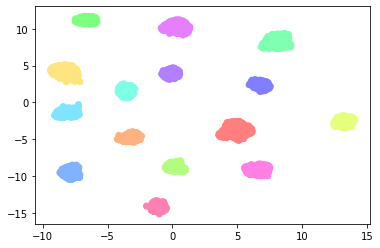

In [164]:
for x in range(15):
    embs = embed_2d[cluster_assignement==x]
    c = [x/255 for x in hsv_to_rgb(x/15)]
    plt.scatter(embs[:, 0], embs[:, 1], c=[c] * len(embs))


In [168]:
cluster_map = dict(zip(df['id'].values_host, cluster_assignement))

In [6]:
data = pd.read_csv('train.csv')

In [170]:
data['cluster_id'] = data['id'].map(lambda x: cluster_map[x])

In [171]:
colors = {
            'Lead': '#8000ff',
            'Position': '#2b7ff6',
            'Evidence': '#2adddd',
            'Claim': '#80ffb4',
            'Concluding Statement': 'd4dd80',
            'Counterclaim': '#ff8042',
            'Rebuttal': '#ff0000'
         }
options = {"ents": list(colors.keys()), "colors": colors}

In [7]:
c = Counter()
for z in data.discourse_text.values:
    c.update(z)

In [8]:
sorted(c.items(), key=lambda x: x[1])

[('ó', 1),
 ('^', 1),
 ('£', 1),
 ('Ó', 1),
 ('\x83', 1),
 ('©', 1),
 ('º', 1),
 ('Ë', 1),
 ('þ', 1),
 ('®', 1),
 ('å', 1),
 ('<', 1),
 ('>', 2),
 ('°', 2),
 ('\x91', 2),
 ('¬', 2),
 ('\x85', 3),
 ('@', 5),
 ('\x80', 5),
 ('â', 5),
 ('|', 6),
 ('{', 6),
 ('~', 6),
 ('}', 7),
 ('¢', 7),
 ('=', 19),
 ('\\', 20),
 ('*', 29),
 ('\x97', 63),
 ('Z', 71),
 ('X', 74),
 ('Q', 74),
 ('\x94', 81),
 ('\x93', 81),
 ('+', 85),
 ('\x92', 102),
 ('#', 111),
 ('\x82', 126),
 ('Ã', 130),
 ('Â', 137),
 ('`', 165),
 ('´', 231),
 ('¨', 251),
 ('&', 252),
 (']', 278),
 ('[', 289),
 ('$', 628),
 ('%', 1652),
 ('K', 1680),
 ('/', 2017),
 (':', 2104),
 ('J', 2211),
 ('4', 3095),
 ('8', 3206),
 ('6', 3288),
 (';', 3358),
 ('7', 3543),
 ('_', 3561),
 ('!', 3639),
 ('(', 4188),
 (')', 4224),
 ('5', 4796),
 ('9', 4833),
 ('3', 5210),
 ('U', 5660),
 ('R', 5843),
 ('Y', 8180),
 ('2', 8388),
 ('L', 8407),
 ('G', 9531),
 ('1', 9598),
 ('?', 11067),
 ('D', 11633),
 ('z', 11834),
 ('H', 11973),
 ('O', 12465),
 ('V', 133

In [10]:
print('\x82')




In [175]:
data.loc[data.discourse_id==1623258656795.0, 'discourse_text'] =  data.loc[data.discourse_id==1623258656795.0, 
                                                                           'discourse_text'].map(lambda x: x.replace('florida', 'LOCATION_NAME')).values

In [176]:
def show_sample(ID):
    with open(f'train/{ID}.txt') as f:
        org_text = f.read()
    dsc = data.loc[data.id==ID].sort_values('discourse_start')
    ents = []
    pointer = 0
    for _, row in dsc.iterrows():
        entity = row.discourse_text.strip()
        starts_at = org_text[pointer:].index(entity) + pointer
        ents.append({'start': starts_at, 'end': starts_at + len(entity), 'label': row.discourse_type})
        pointer = starts_at + len(entity)
    displacy.render({'text': org_text, 'ents': ents, 'title': ID}, style="ent",
                    options=options, manual=True, jupyter=True)

In [177]:
regexp = re.compile('(?s:.)*[a-zA-z0-9].*')

In [178]:
other_chunks_rel_map = {}
other_chunks_abs_map = {}
other_chunks_num_map = {}
num_other_chunks = [[] for _ in range(15)]
mean_abs_size_other_chunks = [[] for _ in range(15)]
mean_rel_size_other_chunks = [[] for _ in range(15)]
for ID in tqdm(ids):
    other_chunks = []
    with open(f'train/{ID}.txt') as f:
        org_text = f.read()
    segment_sizes = []
    dsc = data.loc[data.id==ID].sort_values('discourse_start')
    ents = []
    pointer = 0
    for _, row in dsc.iterrows():
        entity = row.discourse_text.strip()
        segment_sizes.append(len(entity))
        offset = org_text[pointer:].index(entity)
        if offset > 0:
            stripped_bit = org_text[pointer: pointer + offset].strip()
            if len(stripped_bit) and  regexp.match(stripped_bit) is not None:
                offset_text_size = len(stripped_bit)
                other_chunks.append(offset_text_size)
        starts_at = offset + pointer
        ents.append({'start': starts_at, 'end': starts_at + len(entity), 'label': row.discourse_type})
        pointer = starts_at + len(entity)
    index_sets = [set(range(x['start'], x['end'])) for x in ents]
    if len(index_sets) > 2:
        for a in range(len(index_sets)):
            for b in range(a + 1, len(index_sets)):
                 assert not index_sets[a].intersection(index_sets[b])
                    
    mean_segment_size = np.mean(segment_sizes)
    num_other_chunks[dsc.iloc[0].cluster_id].append(len(other_chunks))
    mean_abs_size_other_chunks[dsc.iloc[0].cluster_id].append(0 if not len(other_chunks) else np.mean(other_chunks))
    mean_rel_size_other_chunks[dsc.iloc[0].cluster_id].append(0 if not len(other_chunks) else np.mean(other_chunks) / mean_segment_size)

    other_chunks_rel_map[ID] = 0 if not len(other_chunks) else np.mean(other_chunks) / mean_segment_size
    other_chunks_abs_map[ID] = 0 if not len(other_chunks) else np.mean(other_chunks)
    other_chunks_num_map[ID] = len(other_chunks)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 15594/15594 [01:37<00:00, 159.77it/s]


In [179]:
all_ids = list(other_chunks_num_map.keys())

In [741]:
show_sample(all_ids[np.argmax([other_chunks_rel_map[x] for x in all_ids])])

In [181]:
ents_map = dict(zip(colors.keys(), range(len(colors))))
ents_map

{'Lead': 0,
 'Position': 1,
 'Evidence': 2,
 'Claim': 3,
 'Concluding Statement': 4,
 'Counterclaim': 5,
 'Rebuttal': 6}

In [182]:
def count_entities(x):    
    ent_counts = np.zeros(7)
    for _, z in x.iterrows():
        ent_counts[ents_map[z.discourse_type]] += 1
    return ent_counts

In [184]:
[sum([x > .5 for x in mean_rel_size_other_chunks[z]]) for z in range(15)]

[129, 106, 46, 15, 23, 76, 120, 44, 83, 117, 73, 20, 137, 19, 81]

In [185]:
nseeds = 5
nfolds = 5
all_splits = {}
for seed in range(nseeds):
    all_splits[seed] = {}
    for nn in tqdm((25, 50, 100, 150, 250)):
        all_splits[seed][nn] = {}
        for normed, key in zip((True, False),
                               ('normed', 'not_normed')):
            fold_ids = [[] for _ in range(nfolds)]
            for cluster_id in range(15):
                cluster_data = data.loc[data.cluster_id==cluster_id]
                cluster_counts = cluster_data.groupby('id').apply(count_entities)
                cluster_ids = cluster_counts.index
                much_free_text_ids = set(x for x in cluster_ids if other_chunks_rel_map[x] > .5)
                sorted_much_free_text_ids = sorted(much_free_text_ids, key=lambda x: other_chunks_rel_map[x])
                cluster_ent_embs = np.vstack(cluster_counts.values)
                if normed:
                    cluster_ent_embs /= (np.quantile(cluster_ent_embs, .75, axis=0,) + 1)
                umap = UMAP(n_neighbors=nn, n_components=1, random_state=seed)
                embs_1d = umap.fit_transform(cupy.array(cluster_ent_embs))    
                sorted_index = np.argsort(embs_1d.get().ravel())
                for fold in range(nfolds):
                    fold_ids[fold].extend(x for x in cluster_ids[sorted_index[fold::5]] if x not in much_free_text_ids)
                    fold_ids[fold].extend(sorted_much_free_text_ids[fold::5])
            for a in range(nfolds):
                for b in range(a+1, nfolds):
                    assert not set(fold_ids[a]).intersection(set(fold_ids[b]))
            all_splits[seed][nn][key] = fold_ids

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:13<00:00, 14.75s/it]


In [188]:
with open('data_splits.pickle', 'wb') as f:
    import dill as pickle
    pickle.dump(all_splits, f)

In [190]:
[len(x) for x in all_splits[0][250]['normed']]

[3140, 3121, 3139, 3096, 3098]